# Deep CNN Model Training using Transfer Learning
**In this tutorial, we will intorduce concept of transfer learning in state-of-art CNNs.** 

* Transfer learning is a method where knowledge gathered from one problem are used to solve similar or new problem.
* Transfer learning is usually done for tasks where your dataset has too little data to train a full-scale model from scratch.

**A. How to perform transfer learning?**
1. Take layers from a previously trained model.
2. Freeze all/some initial layers of the model.
3. Add some new layers in the model.
4. Train the new layers on new dataset.

**B. How to perform fine-tuning?**
1. Unfreezing the entire model 
2. Re-training it on the new data

**Move to the folder where dataset is uploaded in Google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%cd /content/drive/My\ Drive/NIELIT_practical/COVID\ Data/DATA1

/content/drive/My Drive/NIELIT_practical/COVID Data/DATA1


**List the files and folders present in the Google drive folder**

In [ ]:
!ls

test  train


#### **Dataset Preparation**

**Import necessary packages**

In [ ]:
import os
import numpy as np
import tensorflow.keras

**Data Preprocessing**

Keras provides the ImageDataGenerator class for data preprocessing and data augmentation.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   horizontal_flip=True, vertical_flip=True, 
                                   rotation_range=15,
                                   shear_range=15,
                                   zoom_range=0.15)
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'train',
        target_size=(224, 224),
        batch_size=8,
        class_mode='categorical'
        )
 

test_generator = test_datagen.flow_from_directory(
        'test',
        target_size=(224, 224),
        batch_size=8,
        class_mode='categorical',
        shuffle=False)

validation_generator = test_generator

Found 547 images belonging to 2 classes.
Found 77 images belonging to 2 classes.


In [ ]:
# horizontal_flip=True, vertical_flip=True- will do data augumentation in training not in testing or validation)

**A. Implementation of tranfer learning using keras:**

1. Instantiate a base model and load pre-trained weights into it.
2. Freeze all layers in the base model by setting trainable = False.
3. Create a new model on top of the output of one (or several) layers from the base model.
4. Train new model on new dataset.


**A.1 Loading the ResNet50 model with ImageNet pre-trained weights**

In [ ]:
base_model = tensorflow.keras.applications.ResNet50(
    include_top=False, 
    weights="imagenet",
    input_shape=(224, 224, 3)
)
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

**A.2 Freeze all the layers of ResNet50**

In [ ]:
base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

**A.3 Adding new layers to ResNet model**


In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
 
# Create the model
model = models.Sequential()
# Add the resnet convolutional base model
model.add(base_model)

# Add new layers
model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dense(2, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_10  (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


**A.4 Model Compilation**

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

**A.5 Model Training**

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath='best_weights_resnet50.hdf5'
checkpointer=ModelCheckpoint(filepath,monitor='val_acc',mode='max',save_best_only=True,verbose=1)
epochs = 10
history=model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=epochs,
        callbacks=[checkpointer],
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size,
        verbose=1)

Epoch 1/10
68/68 [==============================] - 10s 110ms/step - loss: 0.6779 - acc: 0.6067 - val_loss: 0.6835 - val_acc: 0.5556

Epoch 00001: val_acc improved from -inf to 0.55556, saving model to best_weights_resnet50.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
68/68 [==============================] - 7s 100ms/step - loss: 0.6594 - acc: 0.6456 - val_loss: 0.7155 - val_acc: 0.5556

Epoch 00002: val_acc did not improve from 0.55556
Epoch 3/10
68/68 [==============================] - 7s 101ms/step - loss: 0.6815 - acc: 0.5881 - val_loss: 0.6360 - val_acc: 0.9028

Epoch 00003: val_acc improved from 0.55556 to 0.90278, saving model to best_weights_resnet50.hdf5
Epoch 4/10
68/68 [==============================] - 7s 101ms/step - loss: 0.6388 - acc: 0.6324 - val_loss: 0.6186 - val_acc: 0.6250

Epoch 00004: val_acc did not improve from 0.90278
Epoch 5/10
68/68 [==============================] - 7s 103ms/step - loss: 0.6153 - acc: 0.6753 - val_loss: 0.6022 - val_acc: 0.8194

Epoch 00005: val_acc did not improve from 0.90278
Epoch 6/10
68/68 [==============================] - 7s 100ms/step - loss: 0.6410 - acc: 0.6345 - val_loss: 0.5987 - val_acc: 0.6250

Epoch 00006: val_acc did not improve from 0.90278
Epoch 7/10
68/68 [===================

**A.6 Testing the performance of the model**

In [ ]:
test_output= model.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
print(test_output)
print(model.metrics_names)

9/9 [==============================] - 0s 42ms/step - loss: 0.5484 - acc: 0.9221
[0.5483624935150146, 0.9220778942108154]
['loss', 'acc']


**A.7 Plotting the training accuracy and loss graph**

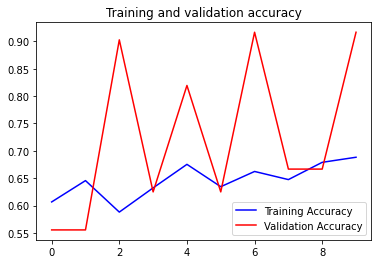

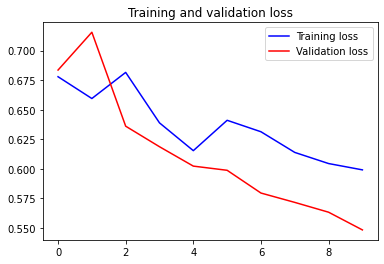

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

###**Fine-tuning**

**B.1 Loading the ResNet50 model with ImageNet pre-trained weights**

In [ ]:
new_base_model = tensorflow.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224,3)
)
new_base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

**B.2 Adding new layers to ResNet model**


In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
 
# Create the model
new_model = models.Sequential()
# Add the resnet convolutional base model
new_model.add(new_base_model)

# Add new layers
new_model.add(layers.GlobalAveragePooling2D())

new_model.add(layers.Dense(2, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
new_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_9 ( (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
loss = tensorflow.keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = tensorflow.keras.optimizers.Adam(
    learning_rate=0.00001, amsgrad=False,
    name='Adam')
new_model.compile(loss=loss, optimizer=optimizer, metrics=['acc'])

**B.4 Model Training**

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath='finetuning_best_weights.hdf5'
checkpointer=ModelCheckpoint(filepath,monitor='val_acc',mode='max',save_best_only=True,verbose=1)
epochs = 20
new_history=new_model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=epochs,
        callbacks=[checkpointer],
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size,
        verbose=1)

Epoch 1/20
68/68 [==============================] - 14s 135ms/step - loss: 0.3125 - acc: 0.9099 - val_loss: 1.0393 - val_acc: 0.4722

Epoch 00001: val_acc improved from -inf to 0.47222, saving model to finetuning_best_weights.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
68/68 [==============================] - 9s 125ms/step - loss: 0.1588 - acc: 0.9499 - val_loss: 1.4555 - val_acc: 0.5556

Epoch 00002: val_acc improved from 0.47222 to 0.55556, saving model to finetuning_best_weights.hdf5
Epoch 3/20
68/68 [==============================] - 9s 127ms/step - loss: 0.1318 - acc: 0.9499 - val_loss: 1.8078 - val_acc: 0.5556

Epoch 00003: val_acc did not improve from 0.55556
Epoch 4/20
68/68 [==============================] - 8s 124ms/step - loss: 0.1278 - acc: 0.9629 - val_loss: 1.6962 - val_acc: 0.5556

Epoch 00004: val_acc did not improve from 0.55556
Epoch 5/20
68/68 [==============================] - 9s 124ms/step - loss: 0.1312 - acc: 0.9499 - val_loss: 1.4153 - val_acc: 0.5556

Epoch 00005: val_acc did not improve from 0.55556
Epoch 6/20
68/68 [==============================] - 9s 124ms/step - loss: 0.0964 - acc: 0.9703 - val_loss: 1.0103 - val_acc: 0.6667

Epoch 00006: val_acc improved from 0.55556 to 0.66667, saving model to finetuning_bes

**B.5 Testing the performance of the model**

In [ ]:
test_output= new_model.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
print(test_output)
print(model.metrics_names)

9/9 [==============================] - 0s 42ms/step - loss: 0.2374 - acc: 0.8961
[0.23736891150474548, 0.8961039185523987]
['loss', 'acc']


**B.6 Plotting the training accuracy and loss graph**

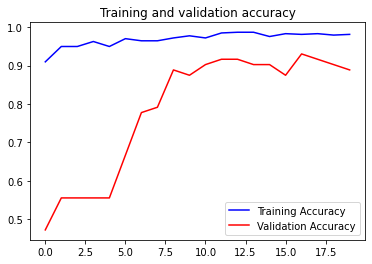

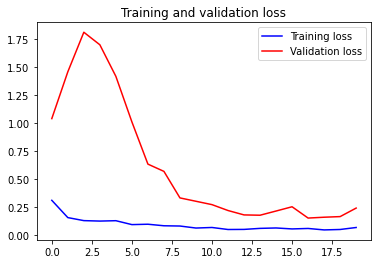

In [ ]:
import matplotlib.pyplot as plt
acc = new_history.history['acc']
val_acc = new_history.history['val_acc']
loss = new_history.history['loss']
val_loss = new_history.history['val_loss']
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()